In [1]:
import pandas as pd 
import numpy as np
import random
import datetime
import sklearn.linear_model as skl_lm
import matplotlib.pyplot as plt 
import utilities as utils
import fractionalDiff as fd
import pickle
import scipy.stats as sps

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
overallScores = pd.read_csv('out_data/hour_2022-06-15_kpca.csv')
orders = overallScores.order.unique()
windows = overallScores.window.unique()
# iterations = overallScores.iteration.unique()


In [25]:
overallScores


,window,simulationDate,ticker,trainScore,testScore,alternativeMdlTestScore,strategyReturn,alternativeMdlStrategyReturn,assetReturn,order
0,2,2022-06-04 06:00:00,indicator,0,0.0,0.0,-0.002130,-0.002130,-0.002130,0.1
1,2,2022-06-04 07:00:00,indicator,0,0.0,0.0,-0.001431,-0.001431,-0.000569,0.1
2,2,2022-06-04 08:00:00,indicator,0,1.0,1.0,-0.000796,-0.000796,-0.000796,0.1
3,2,2022-06-04 11:00:00,indicator,0,0.0,0.0,-0.001166,-0.001166,-0.000834,0.1
4,2,2022-06-04 12:00:00,indicator,0,0.0,0.0,-0.002622,-0.002622,-0.002622,0.1
...,...,...,...,...,...,...,...,...,...,...
51185,24,2022-06-14 04:00:00,indicator,0,0.0,1.0,-0.027877,0.025877,0.025877,1.0
51186,24,2022-06-14 05:00:00,indicator,0,1.0,0.0,0.005783,-0.007783,-0.007783,1.0
51187,24,2022-06-14 06:00:00,indicator,0,0.0,0.0,-0.036008,-0.036008,0.034008,1.0
51188,24,2022-06-14 07:00:00,indicator,0,1.0,0.0,0.003987,-0.005987,-0.005987,1.0


In [26]:
groupByColumns = ['order', 'window']
outputColumns = groupByColumns + ['count', 'testScore', 'skew', 'kurt', 'testStd', 
    'strategyReturn', 'LRStd', 'alternativeMdlTestScore', 'amSkew', 'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn', 'NNstd', 'assetReturn']

aggScores = overallScores.groupby(groupByColumns).agg({'testScore':[np.size, np.mean, sps.skew, sps.kurtosis, np.std], \
    'strategyReturn': [np.sum, np.std], 'alternativeMdlTestScore':[np.mean, sps.skew, sps.kurtosis, np.std], 'alternativeMdlStrategyReturn': [np.median, np.std], 'assetReturn':[np.sum]}).droplevel(level=[0], axis = 1).reset_index()
aggScores.columns = outputColumns

aggScores['nnUb'] = aggScores['NNstd'] + aggScores['alternativeMdlStrategyReturn']
aggScores['nnLb'] =+aggScores['alternativeMdlStrategyReturn'] - aggScores['NNstd']

aggScores['lrUb'] = aggScores['LRStd'] + aggScores['strategyReturn']
aggScores['lrLb'] = aggScores['strategyReturn'] - aggScores['LRStd']

aggScores.sort_values(by = ['strategyReturn'], ascending = False)

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,LRStd,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn,NNstd,assetReturn,nnUb,nnLb,lrUb,lrLb
96,0.5,6,231,0.597403,-0.397220,-1.842216,0.491486,0.219353,0.008817,0.454545,0.182574,-1.966667,0.499011,-0.001561,0.009002,-0.442274,0.007441,-0.010564,0.228170,0.210536
105,0.5,15,230,0.621739,-0.502066,-1.747930,0.486011,0.204044,0.009443,0.460870,0.157003,-1.975350,0.499554,-0.001516,0.009586,-0.501293,0.008070,-0.011102,0.213487,0.194602
52,0.3,8,234,0.572650,-0.293715,-1.913731,0.495754,0.192007,0.009219,0.465812,0.137073,-1.981211,0.499899,-0.001467,0.009346,-0.516664,0.007879,-0.010813,0.201226,0.182787
127,0.6,14,231,0.627706,-0.528346,-1.720850,0.484466,0.191392,0.009433,0.463203,0.147586,-1.978218,0.499727,-0.001471,0.009565,-0.503600,0.008094,-0.011036,0.200826,0.181959
173,0.8,14,231,0.614719,-0.471451,-1.777734,0.487719,0.186039,0.009438,0.463203,0.147586,-1.978218,0.499727,-0.001471,0.009565,-0.503600,0.008094,-0.011036,0.195476,0.176601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1.0,2,132,0.507576,-0.030307,-1.999082,0.501847,-0.163413,0.008464,0.477273,0.091003,-1.991718,0.501386,-0.001226,0.008437,-0.274630,0.007211,-0.009663,-0.154949,-0.171877
161,0.8,2,132,0.477273,0.091003,-1.991718,0.501386,-0.170243,0.008463,0.477273,0.091003,-1.991718,0.501386,-0.001226,0.008437,-0.274630,0.007211,-0.009663,-0.161781,-0.178706
3,0.1,5,225,0.462222,0.151544,-1.977034,0.499682,-0.206079,0.008801,0.457778,0.169494,-1.971272,0.499325,-0.001471,0.008759,-0.450936,0.007288,-0.010231,-0.197278,-0.214880
26,0.2,5,225,0.457778,0.169494,-1.971272,0.499325,-0.207025,0.008801,0.457778,0.169494,-1.971272,0.499325,-0.001471,0.008759,-0.450936,0.007288,-0.010231,-0.198224,-0.215826


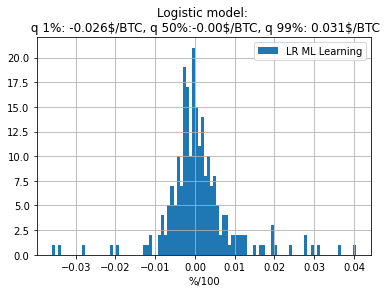

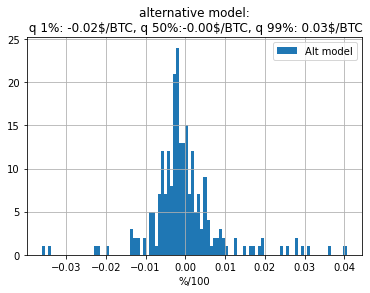

In [28]:
stats = overallScores.loc[(overallScores.order == orders[4]) & (overallScores.window == 6)]
stats.strategyReturn.hist(bins = 100)
plt.title(f'Logistic model: \n q 1%: {np.quantile(stats.strategyReturn, 0.01):.3f}$/BTC, q 50%:{stats.strategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.strategyReturn, 0.99):.3f}$/BTC')
plt.xlabel('%/100')
plt.legend(['LR ML Learning'])
plt.show()
stats.alternativeMdlStrategyReturn.hist(bins = 100)
plt.title(f'alternative model:\n q 1%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.01):.2f}$/BTC, q 50%:{stats.alternativeMdlStrategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.99):.2f}$/BTC')
plt.xlabel('%/100')
plt.legend(['Alt model'])
plt.show()

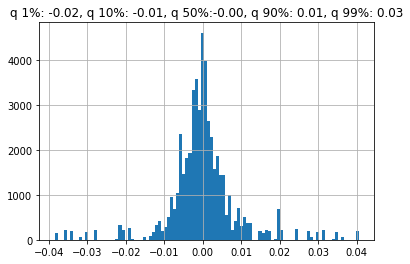

In [29]:
overallScores.strategyReturn.hist(bins = 100)
plt.title(f'q 1%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.01):.2f}, q 10%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.1):.2f}, q 50%:{overallScores.alternativeMdlStrategyReturn.median():.2f}, q 90%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.9):.2f}, q 99%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.99):.2f}')
plt.show()

In [9]:
aggScores.columns

Index(['order', 'window', 'count', 'testScore', 'skew', 'kurt', 'testStd',
       'strategyReturn', 'LRStd', 'alternativeMdlTestScore', 'amSkew',
       'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn', 'NNstd',
       'assetReturn', 'NNPercentError', 'LRPercentError'],
      dtype='object')

In [32]:
aggScores

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,LRStd,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn,NNstd,assetReturn,nnUb,nnLb,lrUb,lrLb
0,0.1,2,132,0.477273,0.091003,-1.991718,0.501386,-0.032641,0.008434,0.477273,0.091003,-1.991718,0.501386,-0.001226,0.008437,-0.274630,0.007211,-0.009663,-0.024207,-0.041075
1,0.1,3,193,0.512953,-0.051831,-1.997314,0.501132,-0.115396,0.008055,0.450777,0.197852,-1.960854,0.498865,-0.001587,0.008059,-0.347257,0.006473,-0.009646,-0.107341,-0.123451
2,0.1,4,216,0.541667,-0.167248,-1.972028,0.499418,-0.025511,0.008343,0.449074,0.204769,-1.958070,0.498555,-0.001574,0.008370,-0.376134,0.006796,-0.009944,-0.017168,-0.033854
3,0.1,5,225,0.462222,0.151544,-1.977034,0.499682,-0.206079,0.008801,0.457778,0.169494,-1.971272,0.499325,-0.001471,0.008759,-0.450936,0.007288,-0.010231,-0.197278,-0.214880
4,0.1,6,231,0.567100,-0.270848,-1.926641,0.496553,0.144810,0.008883,0.454545,0.182574,-1.966667,0.499011,-0.001561,0.009002,-0.442274,0.007441,-0.010564,0.153692,0.135927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1.0,20,225,0.568889,-0.278209,-1.922600,0.496336,-0.041791,0.009693,0.466667,0.133631,-1.982143,0.500000,-0.001463,0.009679,-0.499522,0.008216,-0.011142,-0.032098,-0.051484
226,1.0,21,224,0.593750,-0.381771,-1.854251,0.492232,-0.007157,0.009700,0.468750,0.125245,-1.984314,0.500140,-0.001426,0.009699,-0.500401,0.008273,-0.011125,0.002543,-0.016858
227,1.0,22,223,0.582960,-0.336503,-1.886766,0.494179,0.022500,0.009704,0.470852,0.116791,-1.986360,0.500273,-0.001390,0.009715,-0.495269,0.008325,-0.011105,0.032204,0.012796
228,1.0,23,222,0.603604,-0.423608,-1.820556,0.490254,0.082855,0.009691,0.468468,0.126378,-1.984029,0.500132,-0.001426,0.009737,-0.492625,0.008310,-0.011163,0.092546,0.073164


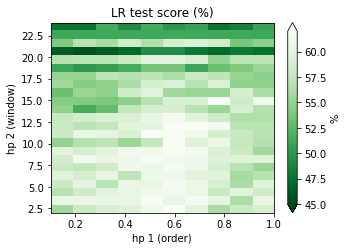

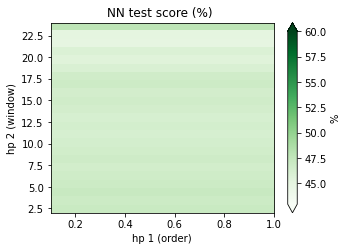

In [42]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
iterations = [0]
ZLR = 100. * aggScores.pivot('window', 'order', 'testScore').values
ZNN = 100. *aggScores.pivot('window', 'order', 'alternativeMdlTestScore').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(45, 62)
plt.title("LR test score (%)")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/LRtestScore.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.Greens, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(50, 60)
plt.title("NN test score (%) ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/NNtestScore.jpeg", dpi=150)

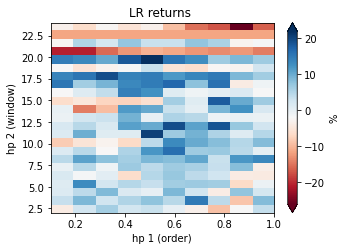

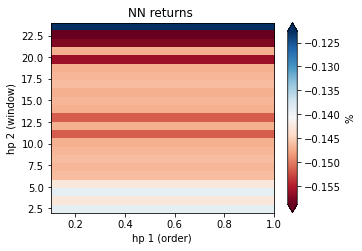

In [41]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = 100.*aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = 100.*aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100.*np.min(aggScores.strategyReturn.values), 100.*np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_lr_kpca_2022-06-15.jpeg", dpi=250)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100.*np.min(aggScores.alternativeMdlStrategyReturn.values), 100.*np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn_negativeOrders_day.jpeg", dpi=250)


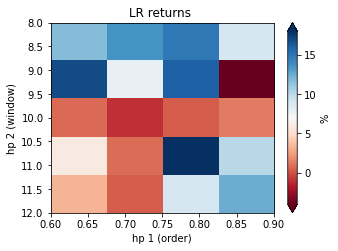

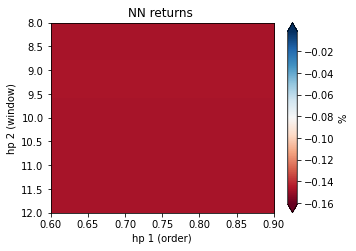

In [23]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.max(aggScores.window.values), np.min(aggScores.window.values)


ZNN = 100*aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = 100*aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(100*np.min(aggScores.strategyReturn.values), 100*np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_lr_kpca.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn_negativeOrders.jpeg", dpi=150)

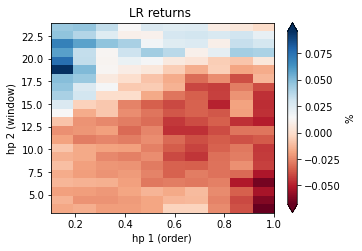

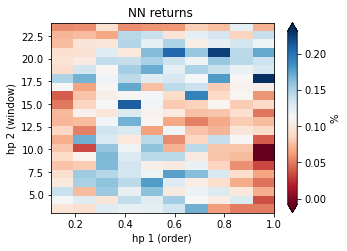

In [42]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn.jpeg", dpi=150)

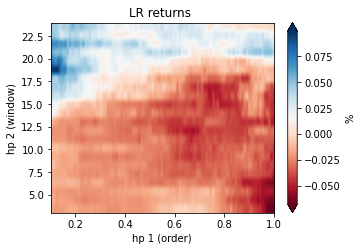

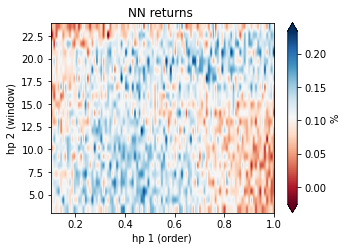

In [47]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('%')
plt.clim(np.min(aggScores.alternativeMdlStrategyReturn.values), np.max(aggScores.alternativeMdlStrategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_wf_nn.jpeg", dpi=150)

In [324]:
aggScoresPre.pivot('window', 'order', 'strategyReturn')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,4223.68,734.64,-1458.84,-208.46,2755.26
9,3013.42,1349.52,-1896.74,-2577.68,-3445.94
10,-639.08,1999.42,-6425.28,-5382.68,-5177.02


In [328]:
aggScoresPre.pivot('window', 'order', 'LRPercentError')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,9.241550,53.173231,26.775002,187.393446,14.173263
9,12.976754,28.985863,20.621657,15.172029,11.346560
10,61.317093,19.595817,6.087701,7.270855,7.560426


In [329]:
aggScores.pivot('window', 'order', 'strategyReturn')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,958.92,2198.80,2252.26,2375.54,4127.22
9,2154.30,3672.10,560.64,1543.94,1986.40
10,1908.64,1619.22,1392.60,1197.18,2126.02


In [330]:
aggScores.pivot('window', 'order', 'LRPercentError')

order,0.500,0.625,0.750,0.875,1.000
window,,,,,
8,20.237555,8.784496,8.573529,8.123011,4.610732
9,9.001758,5.223864,34.771647,12.594861,9.770889
10,10.221536,12.063614,14.038452,16.340089,9.166535


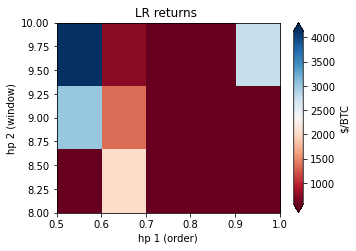

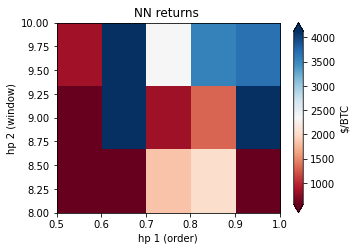

In [320]:
extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)


ZNN = aggScoresPre.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZLR = aggScoresPre.pivot('window', 'order', 'strategyReturn').values

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('$/BTC')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("LR returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_pre_lr.jpeg", dpi=150)

plt.figure(figsize=(5, 3.5))
plt.subplot(1, 1, 1)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
cb = plt.colorbar(extend='both')
cb.set_label('$/BTC')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("NN returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')
plt.savefig(f"imgs/returns_pre_nn.jpeg", dpi=150)


Text(0, 0.5, 'hp 2 (window)')

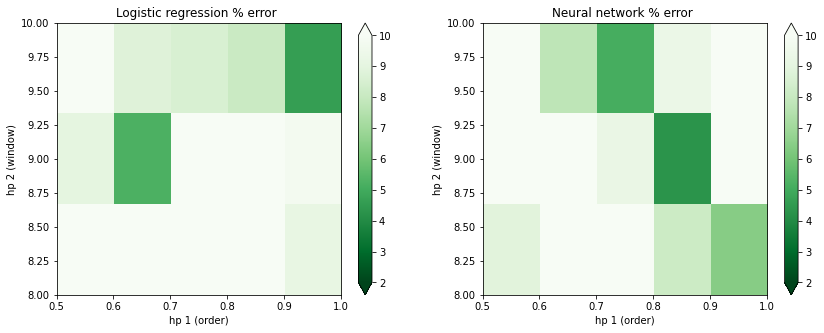

In [325]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'LRPercentError').values
ZNN = aggScores.pivot('window', 'order', 'NNPercentError').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(2, 10)
plt.title("Logistic regression % error ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.Greens_r, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(2, 10)
plt.title("Neural network % error ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

Text(0, 0.5, 'hp 2 (window)')

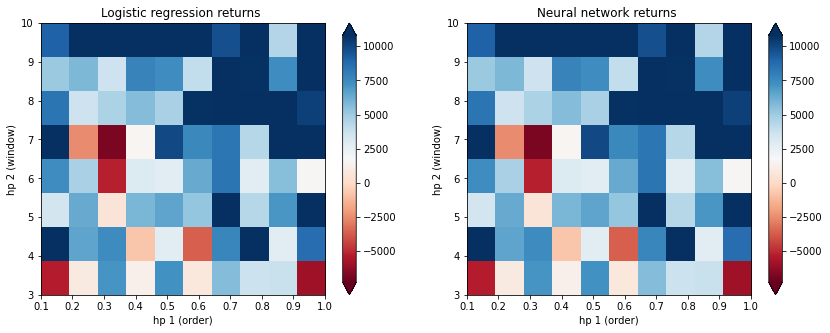

In [258]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZNN2 = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZNN2, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

Text(0, 0.5, 'hp 2 (window)')

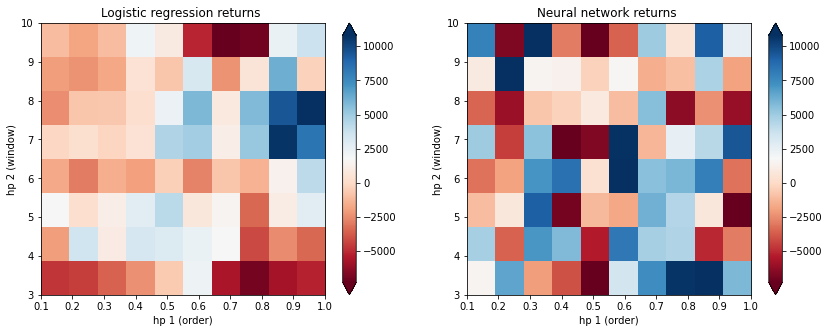

In [229]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

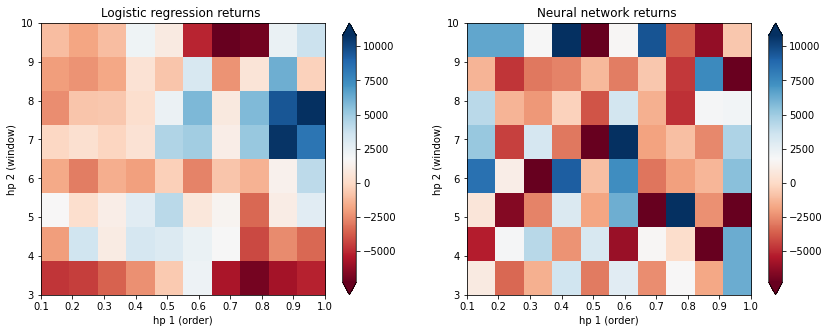

In [224]:
plt.figure(figsize=(14, 5))

extent = np.min(aggScores.order.values), np.max(aggScores.order.values), np.min(aggScores.window.values), np.max(aggScores.window.values)
ZLR = aggScores.pivot('window', 'order', 'strategyReturn').values
ZNN = aggScores.pivot('window', 'order', 'alternativeMdlStrategyReturn').values
ZAsset = aggScores.pivot('window', 'order', 'assetReturn').values

plt.subplot(1, 2, 1)
plt.imshow(ZLR, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Logistic regression returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.subplot(1, 2, 2)
plt.imshow(ZNN, cmap = mpl.cm.RdBu, extent = extent, aspect='auto')
plt.colorbar(extend='both')
plt.clim(np.min(aggScores.strategyReturn.values), np.max(aggScores.strategyReturn.values))
plt.title("Neural network returns ")
plt.xlabel(f'hp 1 (order)')
plt.ylabel('hp 2 (window)')

plt.savefig("imgs/pError.jpeg", dpi=150)

In [ ]:
firstOrderDifferences.close.hist(bins = 50)
plt.title(f'q 10%: {np.quantile(firstOrderDifferences.close, 0.1):.2f}, q 50%:{firstOrderDifferences.close.median():.2f}, q 90%: {np.quantile(firstOrderDifferences.close, 0.9):.2f}') 
plt.show()

In [10]:
scoresToPlot = aggScores.groupby(['order']).agg({'alternativeMdlTestScore':np.median, 'alternativeMdlStrategyReturn': np.median, 'testScore':np.median, 'strategyReturn':np.median}).reset_index()
scoresToPlot

,order,alternativeMdlTestScore,alternativeMdlStrategyReturn,testScore,strategyReturn
0,0.1,0.517498,0.018263,0.508877,-0.008846
1,0.2,0.514453,0.019008,0.507879,-0.011045
2,0.3,0.512103,0.018873,0.509113,-0.010469
3,0.4,0.516616,0.021380,0.509952,-0.009347
4,0.5,0.516240,0.022151,0.511457,-0.006987
5,0.6,0.516359,0.019560,0.510584,-0.005657
6,0.7,0.516689,0.020039,0.510016,-0.003694
7,0.8,0.516959,0.024801,0.509674,-0.004985
8,0.9,0.514814,0.025748,0.511512,-0.001203
9,1.0,0.510664,0.011583,0.508691,0.000146


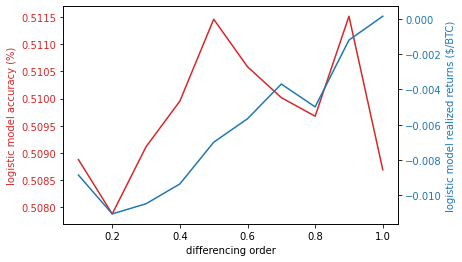

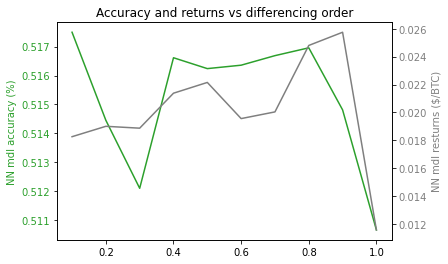

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('differencing order')
ax1.set_ylabel('logistic model accuracy (%)', color=color)
ax1.plot(scoresToPlot.order, scoresToPlot.testScore, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('logistic model realized returns ($/BTC)', color=color)  # we already handled the x-label with ax1
ax2.plot(scoresToPlot.order, scoresToPlot.strategyReturn, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

fig2, ax3 = plt.subplots()

color = 'tab:green'
ax3.set_ylabel('NN mdl accuracy (%)', color=color) 
ax3.plot(scoresToPlot.order, scoresToPlot.alternativeMdlTestScore, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()
color = 'tab:grey'
ax4.set_ylabel('NN mdl resturns ($/BTC)', color=color) 
ax4.plot(scoresToPlot.order, scoresToPlot.alternativeMdlStrategyReturn, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Accuracy and returns vs differencing order')
plt.show()

In [69]:
strategyToPLot

,window,simulationDate,ticker,trainScore,testScore,alternativeMdlTestScore,strategyReturn,alternativeMdlStrategyReturn,assetReturn,order
20120,7,2022-05-03 14:00:00,indicator,0,0.0,1.0,-58.97,58.97,58.97,1.0
20121,7,2022-05-03 15:00:00,indicator,0,0.0,0.0,-183.98,-183.98,-183.98,1.0
20122,7,2022-05-03 16:00:00,indicator,0,1.0,0.0,105.88,-105.88,-105.88,1.0
20123,7,2022-05-03 17:00:00,indicator,0,1.0,1.0,277.82,277.82,-277.82,1.0
20124,7,2022-05-03 18:00:00,indicator,0,1.0,1.0,49.05,49.05,-49.05,1.0
...,...,...,...,...,...,...,...,...,...,...
20389,7,2022-05-14 19:00:00,indicator,0,0.0,0.0,-40.40,-40.40,40.40,1.0
20390,7,2022-05-14 20:00:00,indicator,0,1.0,0.0,321.35,-321.35,321.35,1.0
20391,7,2022-05-14 21:00:00,indicator,0,1.0,1.0,525.66,525.66,525.66,1.0
20392,7,2022-05-14 22:00:00,indicator,0,1.0,1.0,147.97,147.97,-147.97,1.0


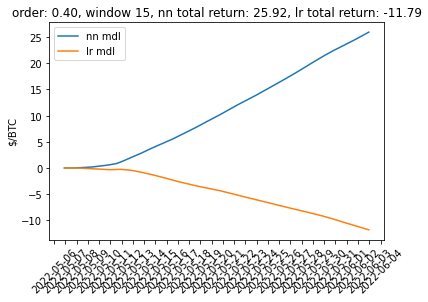

In [12]:
#for window in windows:
window = 15
#xy = scoresToPlot.loc[scoresToPlot.window == window]
for order in [orders[3]]:
    #order = orders[7]
    strategyToPLot = overallScores.loc[(overallScores.window == window) & (overallScores.order == order)]
    dates = []
    for row in strategyToPLot.simulationDate:
        dates.append(mpl.dates.date2num(datetime.datetime.strptime(row, '%Y-%m-%d %H:%M:%S')))
    #strategyToPLotTF = overallScoresTrendFollow.loc[(overallScoresTrendFollow.window == window) & (overallScoresTrendFollow.order == order)]
    fig, ax = plt.subplots()
    ax.plot(dates, strategyToPLot.alternativeMdlStrategyReturn.cumsum())
    ax.plot(dates, strategyToPLot.strategyReturn.cumsum())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    #plt.plot(strategyToPLotTF.simulationDate, strategyToPLotTF.alternativeMdlStrategyReturn.cumsum())
    #plt.plot(scoresToPlot.order, scoresToPlot.realizedReturn)
    plt.title(f'order: {order:.2f}, window {window}, nn total return: {strategyToPLot.alternativeMdlStrategyReturn.sum():.2f}, lr total return: {strategyToPLot.strategyReturn.sum():.2f}')
    plt.xticks(rotation = 45)
    ax.xaxis.set_major_locator(mpl.dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))
    ax.legend(['nn mdl', 'lr mdl'])
    plt.ylabel('$/BTC')
    plt.show()